## Задание 1

In [1]:
#imports
import sys
import numpy as np
import matplotlib.pyplot as plt
import math
import sympy
import pandas
from sympy import init_printing
from IPython.display import display
from numpy import genfromtxt
from mpmath import diff
import time
from matplotlib import animation, rc
from IPython.display import HTML
import functools
init_printing(use_latex='mathjax')

#### Код для отображения прогресс-бара, спасибо https://github.com/alexanderkuk

In [2]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = str(index or '?')

### Пункт 1

In [3]:
mean1 = [0, 0]
mean2 = [3, 3]
cov = [[1, 0], [0, 1]]
x1, y1 = np.random.multivariate_normal(mean1, cov, 750).T
x2, y2 = np.random.multivariate_normal(mean2, cov, 750).T

### Пункт 2

In [4]:
def quadratic_loss_optimization(samples, labels):
    labels = np.asarray(labels)
    np.reshape(labels, (labels.shape[0], 1))
    samples_t = samples.transpose();
    # pseudoinversion in case the matrix here is not invertible 
    return np.linalg.pinv((samples_t @ samples)) @ samples_t @ labels

### Пункт 3

Теперь по сгенерированным данным отобразим на графике оба класса (синий - "1", красный - "-1")

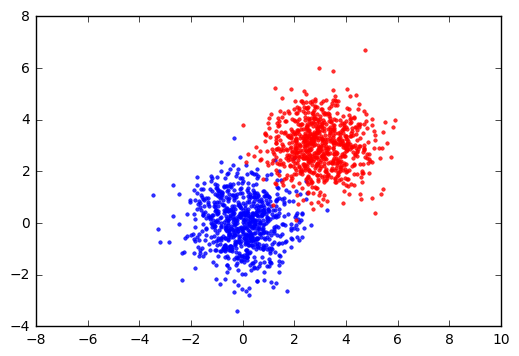

In [5]:
plt.plot(x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.show()

### Пункт 4

In [6]:
x1_t = x1.reshape((x1.shape[0], 1))
y1_t = y1.reshape((y1.shape[0], 1))
x2_t = x2.reshape((x2.shape[0], 1))
y2_t = y2.reshape((y2.shape[0], 1))
samples_1 = np.hstack((x1_t, y1_t))
samples_2 = np.hstack((x2_t, y2_t))
labels_1 = np.ones((x1_t.shape[0], 1))
labels_2 = -np.ones((x2_t.shape[0], 1))
samples = np.vstack((samples_1, samples_2))
prepared_samples = np.hstack((samples, np.ones((samples.shape[0], 1))))
labels = np.vstack((labels_1, labels_2))
analitic_result = quadratic_loss_optimization(prepared_samples, labels)
coefs = analitic_result[:-1, 0]
shift = analitic_result[-1, 0]
print(coefs, shift)

[-0.26191904 -0.28973336] 0.825874360363


Простая функция определения класса

In [7]:
def classify(x, coefs, shift):
    if np.dot(x, coefs) + shift >= 0:
        return 1
    else:
        return -1
labeled_samples = np.apply_along_axis(classify, 1, samples, coefs, shift)

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

misses = samples[labeled_samples != labels[:, 0]].shape[0]

Теперь нарисуем на графике прямую, разбивающую точки на классы, и сами классы

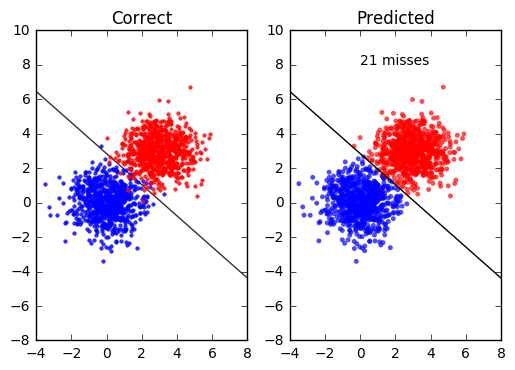

In [8]:
x = [x for x in range(-4, 9)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis([-4, 8, -8, 10])
plt.subplot(122)
plt.title('Predicted')
plt.hold(True)
plt.plot(x, y, 'k-')
plt.scatter(samples_x[:, 0], samples_x[:, 1], c='b', marker='.', s=50, edgecolors='none', alpha=0.7)
plt.scatter(samples_y[:, 0], samples_y[:, 1], c='r', marker='.', s=50, edgecolors='none', alpha=0.7)
plt.text(0, 8, str(misses) + ' misses')
plt.axis([-4, 8, -8, 10])
plt.hold(False)
plt.show()

#### Отступление
Очевидно, что формулировка метода наименьших квадратов не подразумевает существования некоторого вектора-отступа $b$, который присутствует в нашей задаче. Тем не менее, эта задача сводится к методу наименьших квадратов добавлением в вектор признаков каждого элемента дополнительной компоненты $1$, которая по очевидным причинам не зависит от какого-либо элемента выборки и при скалярном произведении элемента на вектор признаков добавлять константу. В дальнейшем мы будем рассматривать уже модифицированную матрицу признаков и считать ассимптотику для неё.
#### Оценим сложность данного алгоритма
Прежде всего, стоит отметить, что для необратимых матриц $X^TX$ формула $w = (X^TX)^{-1}X^TY$ преобразуется в $w = (X^TX)^+X^TY$, где $M^+$ обозначает псевдообратную матрицу. Грубая оценка сложности алгоритма нахождения псевдообратной квадратной матрицы - $O(n^3)$.

Сложность умножения двух матриц определим, как $O(lmn)$ (для матриц $l \times m$ и $m \times n$).
Мы выполняем следующие операции: перемножение матриц $m \times n$ и $n \times m$, их псевдообращение, перемножение результата с матрицей $m \times n$, перемножение результата с матрицей $n \times 1$. Сложность в таком случае составляет $O(nm^2) + O(m^3) + O(nm^2) + O(nm) = O(nm^2) + O(m^3)$, где $n$ - число элементов в выборке, $m$ - число признаков (с единицей)

### Про похожесть на максимизацию правдоподобия
$\mathbb{P}\{y=1|x\} = \sigma(wx+b)$, где $\sigma(z) = \frac{1}{1 + \exp(-z)}$.

Тогда очевидно, что $\mathbb{P}\{y=-1|x\} = 1 - \mathbb{P}\{y=1|x\} = 1 - \frac{1}{1 + \exp(-(wx+b))} = \frac{1 + \exp(-(wx+b)) - 1}{1 + \exp(-(wx+b))} = \frac{\exp(-(wx+b))}{\exp(-(wx+b)) + 1} = \frac{1}{1 + \exp(wx+b)} = \sigma(-wx-b)$

Отсюда для $y \in \{-1, 1\} \; \forall y_i \; \mathbb{P}\{y_i=y \; | x\} = \sigma(y(wx+b))$

Тогда $ \arg\min_{w, b}~\sum_{i}~\ln(1 + \exp(-y_i(wx_i + b))) = \arg\min_{w, b}~\prod_{i}~(1 + \exp(-y_i(wx_i + b)) = \arg\max_{w, b}~\prod_{i}~\frac{1}{1 + \exp(-y_i(wx_i + b))} = \arg\max_{w, b}~\prod_{i}~\sigma(y_i(wx_i+b)) = \arg\max_{w, b}~\prod_{i}~\mathbb{P}\{y=y_i \; | x_i\}$. Таким образом, мы максимизируем по параметрам вероятность того, что для каждого элемента его предсказанный класс совпадает с действительным, что и является максимизацией правдоподобия

### Зависимость Q от M для различных функций потерь

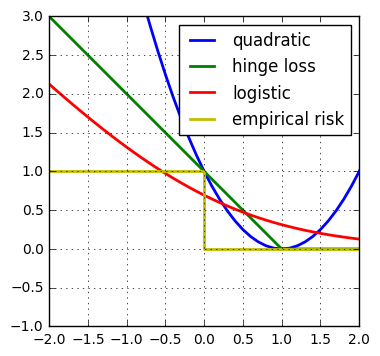

In [9]:
x = [x/10 for x in range(-30, 30)]
y_quad = [(i-1)**2 for i in x]
y_svm = [max(0, 1-i) for i in x]
y_logistic = [math.log(1 + math.exp(-i)) for i in x]
plt.hold(True)
plt.plot(x, y_quad, 'b', label='quadratic', linewidth=2)
plt.plot(x, y_svm, 'g', label='hinge loss', linewidth=2)
plt.plot(x, y_logistic, 'r', label='logistic', linewidth=2)
plt.plot([-2, 0, 0, 3], [1, 1, 0, 0], 'y', label='empirical risk', linewidth=2)
plt.legend(loc='upper right')
plt.hold(False)
plt.axis([-2, 2, -1, 3])
plt.grid()
plt.axes().set_aspect('equal', adjustable='box')
plt.show()

## Градиентный спуск для функции нескольких переменных
В качестве варианта реализации для простоты был выбран градиентный спуск с постоянным шагом

In [10]:
test_function = lambda x,y: 2*x**2 - 12*x + 5*y**2 + 10*y + 26
test_gradient = lambda x,y: np.asarray([4*x - 12, 10*y + 10])

def test_gradient_descent(gradient_function, start, step=0.01, threshold=0.00001, points_log = None, steps_max_number=-1):
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
    step_number = 0
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = gradient_function(*(current_location.tolist()))
        gradient *= step
        current_location -= gradient
        if math.sqrt(np.dot(gradient, gradient)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location
    
step = 0.02
start = [5.0, 5.0] # shoud be random
print('running...')
log = []
result = test_gradient_descent(test_gradient, start, step, points_log=log)
print('finished at point', result, 'after', len(log), 'steps with value', test_function(result[0], result[1]))

running...
finished at point [ 3.00010666 -1.        ] after 119 steps with value 3.00000002275


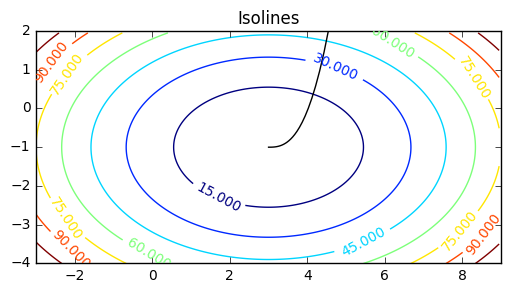

In [11]:
x = np.arange(-3, 9, 0.05)
y = np.arange(-4, 2, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(test_function)
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid)
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x = [p[0] for p in log]
y = [p[1] for p in log]
plt.plot(x, y, 'k-')
plt.axis([-3, 9, -4, 2])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

Было выбрано максимальное значение $\lambda$, с которым алгоритм сходится

#### Тест на функции Розенброка:

running...
finished at point [ 1.00111896  1.00224365] after 171836 steps with value 1.25408082195e-06


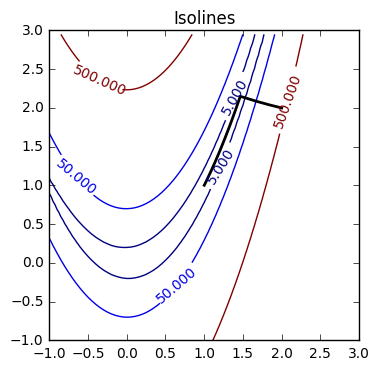

In [12]:
step = 0.0001
start = [2.0, 2.0] # shoud be random
x, y = sympy.symbols('x0:2')
rosenbrock = lambda x,y: (1-x)**2 + 100*(y - x**2)**2
rosenbrock_gradient = lambda x,y: np.asarray([400*x**3 - 400*x*y + 2*x - 2, 200*(y - x**2)])

print('running...')
log = []
result = test_gradient_descent(rosenbrock_gradient, start, step, 1e-7, points_log=log)
print('finished at point', result, 'after', len(log), 'steps with value', rosenbrock(result[0], result[1]))

x = np.arange(-1, 3, 0.05)
y = np.arange(-1, 3, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(rosenbrock)
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid, levels=[5, 50, 500])
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x = [p[0] for p in log]
y = [p[1] for p in log]
plt.plot(x, y, 'k-', linewidth=2)
plt.axis([-1, 3, -1, 3])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

Очевидные из запуска алгоритма пробллемы: при относительно больших $\lambda$ алгоритм расходится, а на множестве сходимости этот шаг очень мал, что в сочетании с тем, что алгоритм зачастую попадает в "овраг" с очень маленькими значениями градиента даёт очень низкую скорость сходимости. В частности, для получения абсолютной погрешности $\approx 10^{-3}$ понадобилось $\approx 2\cdot10^5$ итераций

Решается это изменением логики шага. Например, можно использовать метод наискорейшего спуска, для которого можно проводить очень быстрые одномерные оптимизации, не зависящие от нормы градиента

#### Для начала зададим удобную для работы с обучающей выборкой модификацию функции градиентного спуска

In [13]:
def gradient_descent(samples, labels, start, gradient_function, step=0.01,
                         threshold=0.00001, points_log = None, steps_max_number=-1):
    current_location = np.asarray(start, dtype='float64')
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
        
    step_number = 0
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = gradient_function(samples, labels, current_location)
        gradient *= step
        current_location -= gradient
        if math.sqrt(np.dot(gradient, gradient)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location

#### Протестируем градиентный спуск на начальном наборе точек:

In [14]:
def quadratic_loss_gradient(samples, labels, weights):
    return 2 / samples.shape[0] * np.dot(np.dot(samples, weights) - labels[:, 0], samples)

simple_log = []
simple_result = gradient_descent(prepared_samples, labels, [5, 5, 5], quadratic_loss_gradient, points_log=simple_log)
print(simple_result)

[-0.26204576 -0.28989977  0.82679205]


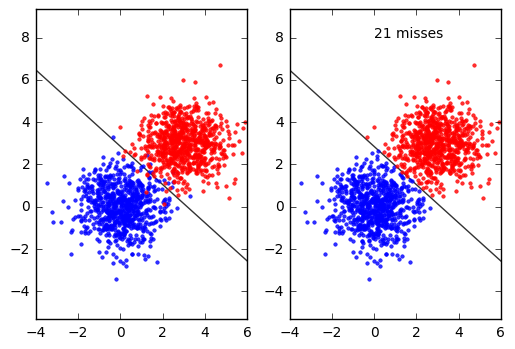

In [15]:
labeled_samples = np.apply_along_axis(classify, 1, samples, simple_result[:2], simple_result[2])
misses = samples[labeled_samples != labels[:, 0]].shape[0]

samples_x = samples[labeled_samples == 1]
samples_y = samples[labeled_samples == -1]

coefs = simple_result[:-1]
shift = simple_result[-1]
x = [x for x in range(-4, 7)]
y = [-(shift + coefs[0]*i)/coefs[1] for i in x]
plt.subplot(121)
plt.title('Correct')
plt.plot(x, y, 'k-', x1, y1, 'b.', x2, y2, 'r.', markersize=5, alpha=0.8)
plt.axis('equal')
plt.subplot(122)
plt.title('Predicted')
plt.plot(x, y, 'k-', samples_x[:, 0], samples_x[:, 1], 'b.', samples_y[:, 0], samples_y[:, 1],
                                                       'r.', markersize=5, alpha=0.8)
plt.text(0, 8, str(misses) + ' misses')
plt.axis('equal')
plt.show()

Разность векторов решений:

In [16]:
print(analitic_result -  np.asarray(simple_result)[np.newaxis].transpose())

[[ 0.00012672]
 [ 0.00016641]
 [-0.00091769]]


Ответ, полученный методом ГС, в данном случае очень близок к аналитическому решению

### Метод наискорейшего спуска
#### Одномерная оптимизация квадратичной функции потерь по направлению:

In [17]:
def quadratic_descent_1d(samples, labels, start, direction, step=0.01):
    a = samples @ direction.transpose()
    b = samples @ start
    best_value = np.sum(a*labels - a*b) / np.sum(a**2)
    return start + direction.transpose()*best_value

#### Наискорейший спуск:

In [18]:
def quadratic_loss_gradient(samples, labels, weights):
    return 2 / samples.shape[0] * (samples @ weights - labels).transpose() @ samples

def steepest_quadratic_descent(samples, labels, start, step=0.01,
                         threshold=0.00001, points_log = None, steps_max_number=-1):
    current_location = np.array(start, dtype='float64', copy=True)[np.newaxis].transpose()
    step_number = 0
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        old_location = current_location.copy()
        gradient = quadratic_loss_gradient(samples, labels, current_location)
        gradient *= step
        current_location  = quadratic_descent_1d(samples, labels, current_location, gradient)
        if math.sqrt(np.sum((old_location - current_location)**2)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location

steepest_log = []
steepest_result = steepest_quadratic_descent(prepared_samples, labels, [5, 5, 5], points_log=steepest_log)

### Сравним теперь скорость сходимости обычного и наискорейшего спуска

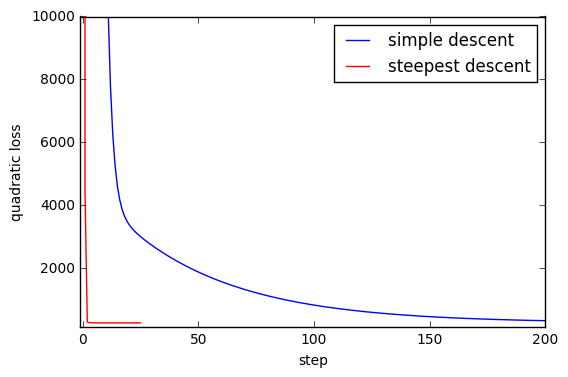

In [19]:
def quadratic_loss_function(samples, labels, weights):
    return np.sum((samples @ weights - labels)**2)

y_simple = [quadratic_loss_function(prepared_samples, labels, np.asarray(weights)[np.newaxis].transpose()) for weights in simple_log]
y_steepest = [quadratic_loss_function(prepared_samples, labels, weights) for weights in steepest_log]
plt.hold(True)
plt.plot(list(range(len(y_simple))), y_simple, 'b-', label='simple descent')
plt.plot(list(range(len(y_steepest))), y_steepest, 'r-', label='steepest descent')
plt.legend(loc='upper right')
plt.hold(False)
plt.axis([-1, 200, 150, 10000])
plt.xlabel('step')
plt.ylabel('quadratic loss')

plt.show()

## Стохастический градиентный спуск

### Создание выборки

In [20]:
def get_subsets(sample_set, label_set, subset_size=1):
    perm = np.random.permutation(len(sample_set))
    shuffled_samples = sample_set[perm]
    shuffled_labels = label_set[perm]
    int_bound = len(shuffled_samples) // subset_size
    for i in range(int_bound):
        yield ((shuffled_samples[i*subset_size:(i+1)*subset_size],
                        shuffled_labels[i*subset_size:(i+1)*subset_size]))

### Получаем данные

In [21]:
data = pandas.read_csv('train.csv', sep=',').as_matrix()


data = data[np.logical_or(data[:, 0] == 0, data[:, 0] == 1)]
samples = data[:8000, 1:]
prepared_samples = np.hstack((samples, np.ones((samples.shape[0], 1))))
labels = data[:8000, 0]
labels = (labels - 0.5) * 2

test_samples = data[8000:, 1:]
prepared_test_samples = np.hstack((test_samples, np.ones((test_samples.shape[0], 1))))
test_labels = data[8000:, 0]
test_labels = (test_labels - 0.5) * 2

### Проводим спуск

for size of 5 after 10 steps there are 3 misses out of 816
for size of 10 after 10 steps there are 2 misses out of 816
for size of 25 after 22 steps there are 2 misses out of 816
for size of 50 after 35 steps there are 2 misses out of 816
for size of 100 after 45 steps there are 2 misses out of 816
for size of 200 after 52 steps there are 2 misses out of 816
for size of 300 after 55 steps there are 2 misses out of 816
for size of 400 after 57 steps there are 2 misses out of 816
for size of 500 after 61 steps there are 2 misses out of 816
for size of 600 after 63 steps there are 2 misses out of 816
for size of 700 after 73 steps there are 2 misses out of 816
for size of 800 after 69 steps there are 2 misses out of 816


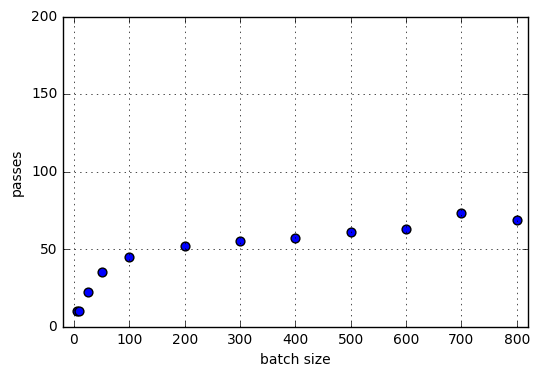

In [22]:
#TODO: optimize it with standart numpy functions
def logistic_loss(samples, labels, weights):
    result = 0.0
    for sample,label in zip(samples, labels):
        result += math.log(1 + math.exp(-label * np.dot(sample, weights)))
    return result / samples.shape[0]

def logistic_gradient(samples, labels, weights):
    result = np.exp(np.multiply(-labels, samples.dot(weights)))
    result = np.divide(result, result + 1)
    result = np.multiply(result, -labels)
    result *= 1 / samples.shape[0]
    return result.dot(samples)

loss_coefs = [x/10 for x in range(1, 10)]
losses = [[] for i in range(9)]
sizes = [5, 10, 25, 50, 100, 200, 300, 400, 500, 600, 700, 800]
simple_size_steps = []
sgd_log = []
for size in sizes:
    current_weights = np.zeros(prepared_samples.shape[1])
    if size == 300:
        sgd_log.append(current_weights)
        for loss_coef, loss in zip(loss_coefs, losses):
            loss.append(logistic_loss(prepared_samples, labels, current_weights))
    steps_number = 0
    while True:  
        old_weights = current_weights.copy()
        for subset in get_subsets(prepared_samples, labels, size):
            current_weights = gradient_descent(subset[0], subset[1], current_weights,
                                               logistic_gradient, step=1e-4, threshold=1e-4, steps_max_number=1)
            if size == 300:
                sgd_log.append(current_weights)
                for loss_coef, loss in zip(loss_coefs, losses):
                    loss.append(loss_coef * loss[-1] + (1 - loss_coef) * logistic_loss(subset[0], subset[1], current_weights))
        steps_number += 1
        if math.sqrt(np.dot(old_weights - current_weights, old_weights - current_weights)) < 1e-4:
            break
    simple_size_steps.append(steps_number)
    labeled_test_samples = np.zeros(prepared_test_samples.shape[0])
    for row in range(test_samples.shape[0]):
        labeled_test_samples[row] = math.copysign(1, prepared_test_samples[row].dot(current_weights))
    misses = test_samples[labeled_test_samples != test_labels].shape[0]
    print('for size of', size, 'after', steps_number, 'steps there are', misses, 'misses out of', test_samples.shape[0])
plt.scatter(sizes, simple_size_steps, s=40)
plt.xlabel('batch size')
plt.ylabel('passes')
plt.axis([-20, 820, 0, 200])
plt.grid(True)
plt.hold(False)
plt.show()

#### Ошибка экспоненциального сглаживания функции потерь (для размера батча 300)

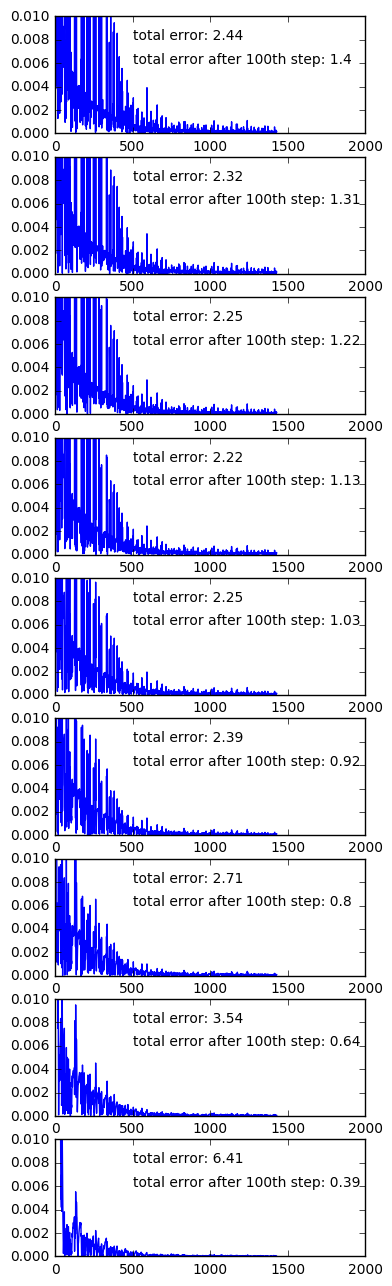

In [23]:
plt.figure(figsize=(4, 16))
plt.hold(False)
for i in log_progress(range(len(losses))):
    plt.subplot(911 + i)
    x = list(range(len(losses[i])))
    y = [abs(losses[i][step] - logistic_loss(prepared_samples, labels, sgd_log[step])) for step in x]
    mean_loss = functools.reduce(lambda x,y: x+y, y)
    mean_loss_100 = functools.reduce(lambda x,y: x+y, y[100:])
    plt.plot(x, y)
    plt.text(500, 0.008, 'total error: ' + str(round(mean_loss, 2)))
    plt.text(500, 0.006, 'total error after 100th step: ' + str(round(mean_loss_100, 2)))
    plt.axis([0, 2000, 0, 0.01])
plt.show()

Из графиков легко заметить, что накопленная ошибка (по сравнению с прямым расчётом значения функции ошибок) растёт с увеличением параметра, отдано если нас интересует только ошибка, начиная с какого-то неначального этапа (на графиках - с 100-го), то лучше выбрать наибольшее значение ($\approx 0.9$)

### Сохранение импульса

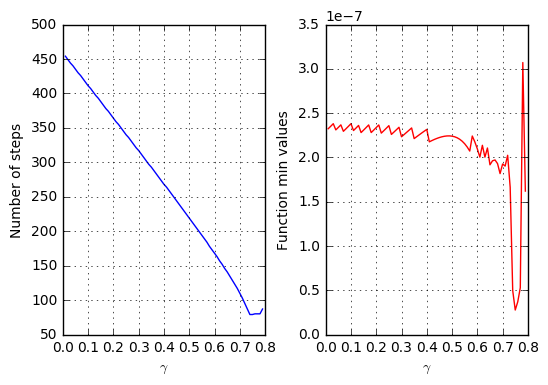

In [24]:
test_function = lambda x,y: 10*x**2 + y**2
test_gradient = lambda x,y: np.asarray([20*x, 2*y])

def momentum_descent(gradient_function, momentum_coef, start, step=0.01, threshold=0.00001,
                     points_log = None, steps_max_number=-1):
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
    step_number = 0
    delta = 0
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        gradient = gradient_function(*(current_location.tolist()))
        gradient *= step
        delta = momentum_coef*delta + gradient
        current_location -= delta
        if math.sqrt(np.dot(gradient, gradient)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location

gammas = [x/100 for x in range(1, 80)]
gamma_steps = []
gamma_values = []
for momentum_coef in gammas:
    momentum_log = []
    momentum_result = momentum_descent(test_gradient, momentum_coef, [5, 5], points_log=momentum_log)
    gamma_steps.append(len(momentum_log))
    gamma_values.append(test_function(momentum_result[0], momentum_result[1]))

plt.subplot(121)
plt.plot(gammas, gamma_steps, 'b')
plt.grid(True)
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.subplot(122)
plt.plot(gammas, gamma_values, 'r')
plt.grid(True)
plt.xlabel('$\gamma$')
plt.ylabel('Function min values')
plt.subplots_adjust(wspace=0.3)
plt.show()

По графику видно, что оптимальным будет выбор $\gamma \approx 0.75$. Отсюда подсчитаем наивным способом и способом с оптимизацией:

467 steps of simple descent, 60 steps of momentum descent


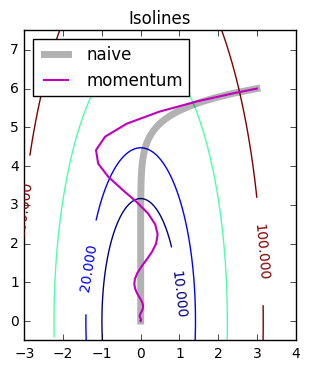

In [25]:
simple_log = []
test_gradient_descent(test_gradient, [3, 6], step=0.01, points_log=simple_log)
momentum_log = []
momentum_descent(test_gradient, 0.75, [3, 6], step=0.01, points_log=momentum_log)
print(len(simple_log), 'steps of simple descent,', len(momentum_log), 'steps of momentum descent')

x = np.arange(-4, 8, 0.05)
y = np.arange(-4, 8, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(test_function)
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid, levels=[10, 20, 50, 100])
plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x_simple = [p[0] for p in simple_log]
y_simple = [p[1] for p in simple_log]
plt.plot(x_simple, y_simple, 'k-', alpha=0.3, linewidth=5, label='naive')
x_momentum = [p[0] for p in momentum_log]
y_momentum = [p[1] for p in momentum_log]
plt.plot(x_momentum, y_momentum, 'm-', linewidth=1.5, label='momentum')
plt.legend(loc='upper left')
plt.axis([-3, 4, -0.5, 7.5])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.show()

Как можно наблюдать, несмотря на некую "неустойчивость" спуска с сохранением импульса, как раз за счёт этого импульса скорость по оси $y$ постепенно увеличивается, за счёт чего уменьшение градиента компенсируется набранной скоростью, и алгоритм сходится быстрее

#### Ускоренный градиент Нестерова

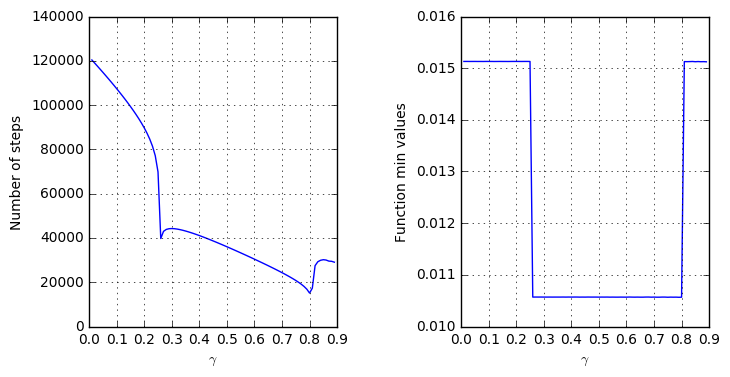

In [26]:
def nesterov_descent(gradient_function, momentum_coef, start, step=1e-4, threshold=1e-5,
                     points_log = None, steps_max_number=-1):
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
    step_number = 0
    delta = np.zeros_like(current_location)
    while step_number != steps_max_number:
        if points_log != None:
            points_log.append(current_location.copy())
        
        plus = current_location - delta
        gradient = gradient_function(*(plus.tolist()))
        gradient *= step
        delta = momentum_coef*delta + gradient
        current_location -= delta
        if math.sqrt(np.dot(gradient, gradient)) < threshold:
            break
        step_number += 1
    if points_log != None:
        points_log.append(current_location)
    return current_location

gammas = [x/100 for x in range(1, 90)]
gamma_steps = []
gamma_values = []
for nesterov_coef in gammas:
    nesterov_log = []
    nesterov_result = nesterov_descent(rosenbrock_gradient, nesterov_coef, [5, 5], points_log=nesterov_log)
    gamma_steps.append(len(nesterov_log))
    gamma_values.append(rosenbrock(nesterov_result[0], nesterov_result[1]))

plt.figure(figsize=(8, 4))
plt.subplots_adjust(wspace=0.5)
plt.subplot(121)
plt.plot(gammas, gamma_steps, 'b')
plt.grid(True)
plt.xlabel('$\gamma$')
plt.ylabel('Number of steps')
plt.subplot(122)
plt.plot(gammas, gamma_values, 'b')
plt.grid(True)
plt.xlabel('$\gamma$')
plt.ylabel('Function min values')
plt.show()

8036 steps of momentum descent, 6468 steps of nesterov descent


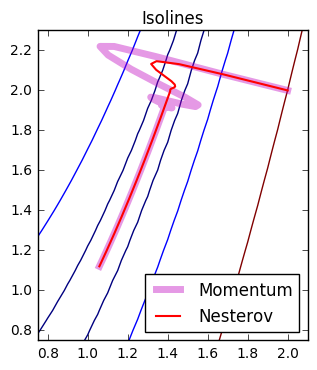

In [27]:
momentum_log = []
momentum_descent(rosenbrock_gradient, 0.74, [2, 2], step=2e-4, threshold=1e-5, points_log=momentum_log)
nesterov_log = []
nesterov_descent(rosenbrock_gradient, 0.8, [2, 2], step=2e-4, threshold=1e-5, points_log=nesterov_log)
print(len(momentum_log), 'steps of momentum descent,', len(nesterov_log), 'steps of nesterov descent')

x = np.arange(-1, 3, 0.05)
y = np.arange(-1, 3, 0.05)
xgrid, ygrid = np.meshgrid(x, y)
eval_func = np.vectorize(rosenbrock)
zgrid = eval_func(xgrid, ygrid)
plt.hold(True)
CS = plt.contour(xgrid, ygrid, zgrid, levels=[5, 50, 400])
# plt.clabel(CS, inline=1, fontsize=10)
plt.title('Isolines')
x_momentum = [p[0] for p in momentum_log]
y_momentum = [p[1] for p in momentum_log]
plt.plot(x_momentum, y_momentum, 'm-', lw=5, alpha=0.4, label='Momentum')
x_nesterov = [p[0] for p in nesterov_log]
y_nesterov = [p[1] for p in nesterov_log]
plt.plot(x_nesterov, y_nesterov, 'r-', lw=1.5, label='Nesterov')
plt.axis([0.75, 2.1, 0.75, 2.3])
plt.axes().set_aspect('equal', adjustable='box')
plt.hold(False)
plt.legend(loc='lower right')
plt.show()

Легко сравнить подходы по скорости сходимости (8к шагов для алгоритма сохранения импульса против 6.5к для алгоритма Нестерова). По трекам заметно, что ускоренный градиент Нестерова также ведёт себя более стабильно при осцилляции вдоль какой-либо оси

### Adagrad

In [28]:
def adagrad(samples, labels, start, G, gradient_function, step=1e-2, threshold=1e-5,
                     points_log = None, steps_max_number=-1):
    EPSILON = 1e-10
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
        
    gradient = gradient_function(samples, labels, current_location)[np.newaxis]
    G += gradient ** 2
    current_location -= (step * gradient / (np.sqrt(G) + EPSILON))[0]
    return current_location

adagrad_size_steps = []
for size in sizes:
    current_weights = np.zeros(prepared_samples.shape[1])
    G = np.zeros_like(current_weights)[np.newaxis]
    steps_number = 0
    while True:
        subsets = get_subsets(prepared_samples, labels, size)
        old_weights = current_weights.copy()
        for subset in subsets:
            current_weights = adagrad(subset[0], subset[1], current_weights, G,
                                               logistic_gradient, step=1e-3)
        steps_number += 1
        if math.sqrt(np.dot(old_weights - current_weights, old_weights - current_weights)) < 1e-3:
            break
    adagrad_size_steps.append(steps_number)
    labeled_test_samples = np.zeros(prepared_test_samples.shape[0])
    for row in range(test_samples.shape[0]):
        labeled_test_samples[row] = math.copysign(1, prepared_test_samples[row].dot(current_weights))
    misses = test_samples[labeled_test_samples != test_labels].shape[0]
    print('for size of', size, 'after', steps_number, 'steps there are', misses, 'misses out of', test_samples.shape[0])

for size of 5 after 16 steps there are 0 misses out of 816
for size of 10 after 13 steps there are 1 misses out of 816
for size of 25 after 12 steps there are 0 misses out of 816
for size of 50 after 14 steps there are 0 misses out of 816
for size of 100 after 17 steps there are 1 misses out of 816
for size of 200 after 19 steps there are 1 misses out of 816
for size of 300 after 24 steps there are 1 misses out of 816
for size of 400 after 22 steps there are 1 misses out of 816
for size of 500 after 33 steps there are 1 misses out of 816
for size of 600 after 29 steps there are 1 misses out of 816
for size of 700 after 33 steps there are 1 misses out of 816
for size of 800 after 30 steps there are 1 misses out of 816


### Adam

In [29]:
def adam(samples, labels, gradient_function, delta, delta_coef, delta_coef_degree,
         G, G_coef, G_coef_degree, start, step=0.01):
    EPSILON = 1e-10
    current_location = np.asfarray(start)
    # existing numpy.ndarray objects are not copied by default
    if current_location is start:
        current_location = start.copy()
    gradient = gradient_function(samples, labels, start)[np.newaxis]
    delta = delta_coef * delta + (1 - delta_coef) * gradient
    G = G_coef * G + (1 - G_coef) * gradient**2
    current_location -= (step / (1 - delta_coef_degree) / (1 - G_coef_degree) * delta / (np.sqrt(G) + EPSILON))[0]
    delta_coef_degree *= delta_coef
    G_coef_degree *= G_coef
    return current_location

delta_coef = 0.1
G_coef = 0.95
adam_size_steps = []
for size in sizes:
    current_weights = np.zeros(prepared_samples.shape[1])
    G = np.zeros_like(current_weights)[np.newaxis]
    delta = 0
    delta_coef_degree = delta_coef
    G_coef_degree = G_coef
    steps_number = 0
    while True:
        subsets = get_subsets(prepared_samples, labels, size)
        old_weights = current_weights.copy()
        for subset in subsets:
            current_weights = adam(subset[0], subset[1], logistic_gradient, delta, delta_coef, delta_coef_degree,
                               G, G_coef, G_coef_degree, current_weights, step=1e-4)
        steps_number += 1
        if math.sqrt(np.dot(old_weights - current_weights, old_weights - current_weights)) < 1e-4:
            break
    adam_size_steps.append(steps_number)
    labeled_test_samples = np.zeros(prepared_test_samples.shape[0])
    for row in range(test_samples.shape[0]):
        labeled_test_samples[row] = math.copysign(1, prepared_test_samples[row].dot(current_weights))
    misses = test_samples[labeled_test_samples != test_labels].shape[0]

    print('for size of', size, 'after', steps_number, 'steps there are', misses, 'misses out of', test_samples.shape[0])

for size of 5 after 11 steps there are 1 misses out of 816
for size of 10 after 11 steps there are 2 misses out of 816
for size of 25 after 12 steps there are 2 misses out of 816
for size of 50 after 18 steps there are 1 misses out of 816
for size of 100 after 21 steps there are 1 misses out of 816
for size of 200 after 10 steps there are 2 misses out of 816
for size of 300 after 14 steps there are 1 misses out of 816
for size of 400 after 24 steps there are 2 misses out of 816
for size of 500 after 14 steps there are 1 misses out of 816
for size of 600 after 12 steps there are 0 misses out of 816
for size of 700 after 18 steps there are 0 misses out of 816
for size of 800 after 20 steps there are 1 misses out of 816


#### Теперь сравним обычный SGD, Adagrad и Adam:

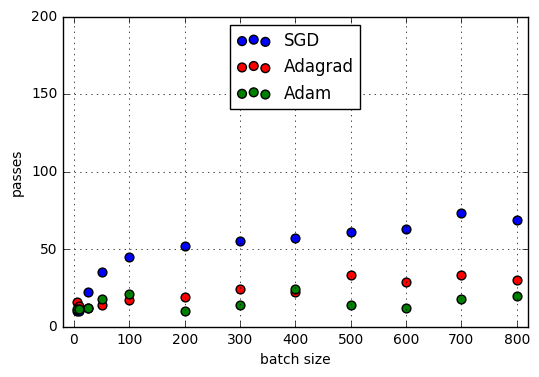

In [30]:
plt.hold(True)
plt.scatter(sizes, simple_size_steps, s=40, c='b', label='SGD')
plt.scatter(sizes, adagrad_size_steps, s=40, c='r', label='Adagrad')
plt.scatter(sizes, adam_size_steps, s=40, c='g', label='Adam')
plt.xlabel('batch size')
plt.ylabel('passes')
plt.axis([-20, 820, 0, 200])
plt.grid(True)
plt.legend(loc='upper center')
plt.hold(False)
plt.show()

Улучшения алгоритма Adam, очевидно, состоят в том, что он одновременно и учитывает "важность" разреженных признаков, как Adagrad, и при этом контролируя рост знаменателя $\sqrt{G}$ этой модели, и в то же контролирует скорость и направление движения градиентного спуска благодаря сохранению импульса, что как ускоряет спуск, так и препятствует осцилляции вдоль какой-либо оси